### PRODUCT RECOMMENDATION ENGINE USING DATA MINING AND MACHINE LEARNING TECHNIQUES
In this project, we aim to build a recommendation engine for an online store that will use customers previous purchase history, predict their preferences and make recommendations based on them. The idea behind the recommendation engine is to boost Customer experience/satisfaction thereby increasing conversion rates and ROI (Return on Investment) for the business. We will be using Market Basket Analysis, Network Analysis, Nearest Neighbors (to cluster items together), content based and collaborative filtering algorithm.
##### Data Source 
Data was gotten on kaggle of 278,677 amazon reviews.

In [164]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
from mlxtend.preprocessing import TransactionEncoder
from warnings import filterwarnings
filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import string
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
# Functions to read in zip jason  file (json.gz)
def parse(path): # Function to open file
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path): # Function to create dataframe from the parsed json file
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
# Read in file - amazon_fashion.json.gz
a_fashion_df = getDF('amazon_fashion.json.gz')


#### DATA EXPLORATION
We will try to get more acquinted with our data set

In [42]:
# View few rows from dataset
a_fashion_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [43]:
# Check the shape of the dataset
a_fashion_df.shape

(278677, 9)

There are 278,677 reviews on different products made by customer. Their are 7 features in the dataset

In [47]:
# check number of products
a_fashion_df.groupby('asin').count()

,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
asin,,,,,,,,
0000031887,23,23,23,23,23,23,23,23
0123456479,6,6,6,6,6,6,6,6
1608299953,13,13,13,13,13,13,13,13
1617160377,16,16,16,16,16,16,16,16
B00001W0KA,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...
B00KA602SY,6,6,6,6,6,6,6,6
B00KCWMG5S,5,5,5,5,5,5,5,5
B00KF9180W,10,10,10,10,10,10,10,10


From the result above, 278,677 reviews were made on 23,033 products. We will dive deeper and do some feature engineering to find the item review count. 

In [50]:
# Calculate item rating count
item_ratingCount = a_fashion_df.groupby('asin')['overall'].count().reset_index().rename(columns = {'overall':'totalRatingCount'})[['asin', 'totalRatingCount']]
item_ratingCount

,asin,totalRatingCount
0,0000031887,23
1,0123456479,6
2,1608299953,13
3,1617160377,16
4,B00001W0KA,8
...,...,...
23028,B00KA602SY,6
23029,B00KCWMG5S,5
23030,B00KF9180W,10
23031,B00KGCLROK,5


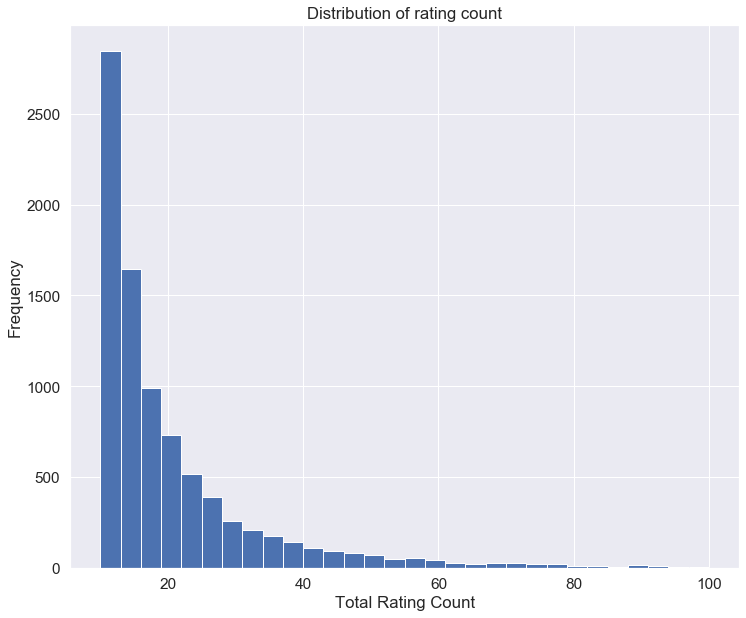

In [72]:
# Plot Distribution of rating count
plt.figure(figsize=(12,10))
plt.hist(item_ratingCount['totalRatingCount'], bins=30, range=[10, 100])
plt.xlabel('Total Rating Count')
plt.ylabel('Frequency') 
plt.title('Distribution of rating count')
plt.show()

We can see that a good percent of products have below 30 reviews. We have fewer items beyond that. This implies that our data is skewed to the left.
We will append the item_rating count to our original dataframe

In [74]:
# Merge item_ratingCount to original dataframe
a_fashion_df = a_fashion_df.merge(item_ratingCount, left_on = 'asin', right_on = 'asin', how = 'left')
a_fashion_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,totalRatingCount
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",23
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",23
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",23
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",23
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",23


In [75]:
# Check the features in amazon_fashion_df 
a_fashion_df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime',
       'totalRatingCount'],
      dtype='object')

In [76]:
# Check for null values
a_fashion_df.isnull().sum()

reviewerID            0
asin                  0
reviewerName        452
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
totalRatingCount      0
dtype: int64

In [ ]:
reviewerName has 452 null values. We will drop those rows as the ratio to the entire dataset is minimal.

In [84]:
# Drop any row having a null value
a_fashion_df.dropna(inplace=True)

In [85]:
a_fashion_df.isnull().sum()

reviewerID          0
asin                0
reviewerName        0
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
totalRatingCount    0
dtype: int64

In [86]:
a_fashion_df.dtypes

reviewerID           object
asin                 object
reviewerName         object
helpful              object
reviewText           object
overall             float64
summary              object
unixReviewTime        int64
reviewTime           object
totalRatingCount      int64
dtype: object

### MARKET BASKET ANALYSIS
We will do a market basket analysis on our data set to get more acquinted with our data set and discover certain purchase pattern like items that are frequently bought together

In [87]:
# 2. Create our list of 'baskets' (collections of reviews) for use with the TransactionEncoder
reviewer_groups = a_fashion_df.groupby('reviewerID')['asin'].apply(list).reset_index()

In [88]:
# 2. Check number of items in dataset
items_no = a_fashion_df.groupby('asin').apply(list).reset_index().count()
items_no

asin    23026
0       23026
dtype: int64

In [90]:
# Create a basket of baskets 
baskets = reviewer_groups.asin.tolist()
len(baskets)

39386

From  23,033 unique items, we end up with 39,387 baskets.

In [13]:
baskets

[['B000J6ZYL0',
  'B0016JNS44',
  'B001T54XA8',
  'B004AZXO1I',
  'B004QJWKLS',
  'B005BXP7R2',
  'B0093STGGO'],
 ['B000JJX7C0',
  'B000MX3SH2',
  'B003CO205E',
  'B006Y4QDVQ',
  'B00823Y41S',
  'B008JXDFCU',
  'B00BQJV1LG'],
 ['B007WADN4G',
  'B007WAEBPQ',
  'B007WAT3I6',
  'B008G51WHQ',
  'B008SBGKP2',
  'B00BLW2PZY'],
 ['B002FA5B8O', 'B003F06XQW', 'B003F8BKGW', 'B00768LFYY', 'B00DVFNNQE'],
 ['B00387EEYA', 'B003RYZY8E', 'B0058XN9ZC', 'B0058YTOP0', 'B00BTWAZ0I'],
 ['B002ECEKE4', 'B0040JB0OW', 'B005FHXPFK', 'B0074BNKLO', 'B008IB4LCQ'],
 ['B001SN8DHU',
  'B00377D096',
  'B003US462C',
  'B004LQLEBS',
  'B008OOMB0Q',
  'B00B99Z43E'],
 ['B001A3Y89A', 'B004LP2ISM', 'B005ZFCUIA', 'B00AFC4O9G', 'B00GOMDIMU'],
 ['B0000868O9', 'B002R9NISS', 'B0058SU5UY', 'B0060MF7L4', 'B00A6SOR7I'],
 ['B0024V67A0', 'B005LXUUXI', 'B00AYCQL8O', 'B00BPNX7MO', 'B00HFPBZWK'],
 ['B0012M0V7W', 'B0018P3EAO', 'B005FSMCCQ', 'B007VIWFXO', 'B00F13N828'],
 ['B003H1445G', 'B004YZ82RA', 'B00527M9HS', 'B007KF1JZS', 'B007XW2UG0

In [14]:
# create a Sparse Transaction matrix dataframe
t_encoder = TransactionEncoder()
transaction_matrix = t_encoder.fit(baskets).transform(baskets, sparse=True)
transaction_df = pd.SparseDataFrame(transaction_matrix, columns=t_encoder.columns_, 
                                    default_fill_value=0).astype(int)


In [15]:
transaction_df.head()

,0000031887,0123456479,1608299953,1617160377,B00001W0KA,B00001WRHJ,B00004SR8W,B00004SR8Z,B00004SR9P,B00004U1J2,...,B00K0BPFY0,B00K551QR6,B00K5T4NHC,B00K8J06CK,B00KA2X4QK,B00KA602SY,B00KCWMG5S,B00KF9180W,B00KGCLROK,B00KKXCJQU
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
transaction_df.sum()

0000031887    23
0123456479     6
1608299953    13
1617160377    16
B00001W0KA     8
              ..
B00KA602SY     6
B00KCWMG5S     5
B00KF9180W    10
B00KGCLROK     5
B00KKXCJQU     9
Length: 23033, dtype: int64

In [17]:
transaction_df.shape

(39387, 23033)

In [18]:
# Find the support for each item
support_series = transaction_df.sum(axis=0)/transaction_df.shape[0]
support_series

0000031887    0.000584
0123456479    0.000152
1608299953    0.000330
1617160377    0.000406
B00001W0KA    0.000203
                ...   
B00KA602SY    0.000152
B00KCWMG5S    0.000127
B00KF9180W    0.000254
B00KGCLROK    0.000127
B00KKXCJQU    0.000229
Length: 23033, dtype: float64

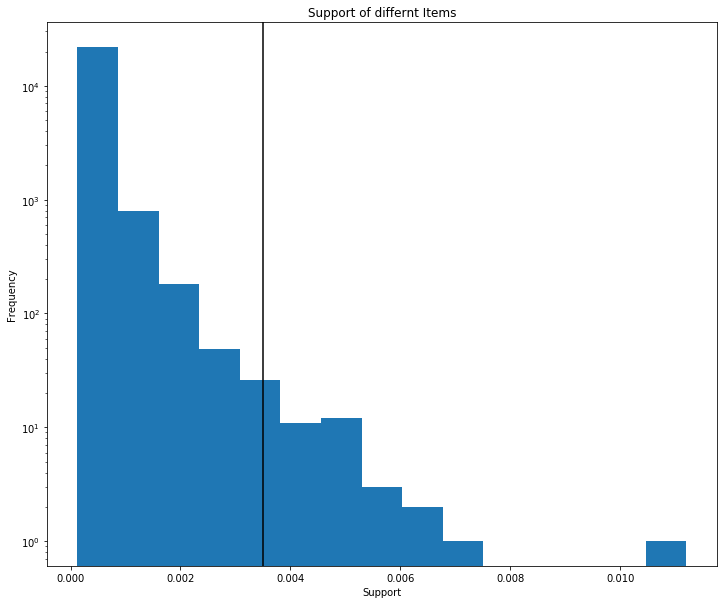

In [19]:
# Plot support of each item
plt.figure(figsize=(12,10))
plt.hist(support_series, bins=15)
plt.yscale('log')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.title('Support of differnt Items')
plt.axvline(0.0035, color='black')
plt.savefig('support.png')
plt.show()


In [20]:
#3. Look at co-occurence for top 30 StockCodes by support
support_series.nlargest(30)

B005LERHD8    0.011197
B005GYGD7O    0.007261
B008WYDP1C    0.006322
B0058XIMMM    0.006119
B00CKGB85I    0.005713
B007RD9DS8    0.005509
B002RADHJC    0.005357
B000T9VK56    0.005256
B0000C321X    0.005205
B0001ZNZJM    0.005002
B007WNWEFC    0.005002
B007WA3K4Y    0.004849
B00012O12A    0.004799
B007NLX16O    0.004799
B0008EOEPK    0.004722
B0007YR8WW    0.004697
B0067GUM2W    0.004646
B000O32MLI    0.004595
B001IB70JY    0.004570
B004Q7AB4I    0.004443
B003NX87U6    0.004265
B006PGGJOE    0.004265
B002PHLVJA    0.004113
B0083S18LQ    0.004088
B008KK0ZJ8    0.004088
B0007YVP1W    0.004011
B005UVM368    0.004011
B000KEG4V0    0.003885
B00DNQIIE8    0.003885
B004YM2FV2    0.003834
dtype: float64

In [21]:
top_30_product = support_series.nlargest(30).index
top_30_product

Index(['B005LERHD8', 'B005GYGD7O', 'B008WYDP1C', 'B0058XIMMM', 'B00CKGB85I',
       'B007RD9DS8', 'B002RADHJC', 'B000T9VK56', 'B0000C321X', 'B0001ZNZJM',
       'B007WNWEFC', 'B007WA3K4Y', 'B00012O12A', 'B007NLX16O', 'B0008EOEPK',
       'B0007YR8WW', 'B0067GUM2W', 'B000O32MLI', 'B001IB70JY', 'B004Q7AB4I',
       'B003NX87U6', 'B006PGGJOE', 'B002PHLVJA', 'B0083S18LQ', 'B008KK0ZJ8',
       'B0007YVP1W', 'B005UVM368', 'B000KEG4V0', 'B00DNQIIE8', 'B004YM2FV2'],
      dtype='object')

The support of an item shows us the frequency at which items appearin different reviews. Items with higher support  More like the most popular or best selling items. 

In [22]:
# Filter the transaction matrix
top30_tx_df = transaction_df[top_30_product]
top30_tx_df

,B005LERHD8,B005GYGD7O,B008WYDP1C,B0058XIMMM,B00CKGB85I,B007RD9DS8,B002RADHJC,B000T9VK56,B0000C321X,B0001ZNZJM,...,B003NX87U6,B006PGGJOE,B002PHLVJA,B0083S18LQ,B008KK0ZJ8,B0007YVP1W,B005UVM368,B000KEG4V0,B00DNQIIE8,B004YM2FV2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39382,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Corellation between products to find items with the highest likelihood of being bought together
correlation_tb = top30_tx_df.T.dot(top30_tx_df.astype('int'))
correlation_tb

,B005LERHD8,B005GYGD7O,B008WYDP1C,B0058XIMMM,B00CKGB85I,B007RD9DS8,B002RADHJC,B000T9VK56,B0000C321X,B0001ZNZJM,...,B003NX87U6,B006PGGJOE,B002PHLVJA,B0083S18LQ,B008KK0ZJ8,B0007YVP1W,B005UVM368,B000KEG4V0,B00DNQIIE8,B004YM2FV2
B005LERHD8,441,0,8,0,2,53,1,2,0,0,...,1,1,1,3,0,0,2,1,36,10
B005GYGD7O,0,286,3,1,5,2,6,1,0,1,...,3,0,0,2,1,0,2,2,0,0
B008WYDP1C,8,3,249,1,4,4,1,0,0,0,...,0,0,1,18,0,0,3,1,6,1
B0058XIMMM,0,1,1,241,0,1,1,0,0,0,...,0,0,3,0,8,0,2,2,0,0
B00CKGB85I,2,5,4,0,225,1,1,0,0,0,...,2,1,0,3,0,1,3,2,1,0
B007RD9DS8,53,2,4,1,1,217,2,0,1,0,...,0,0,0,1,0,1,0,1,33,5
B002RADHJC,1,6,1,1,1,2,211,0,0,0,...,1,1,2,1,0,1,2,23,0,0
B000T9VK56,2,1,0,0,0,0,0,207,2,1,...,1,2,1,0,0,2,0,1,0,1
B0000C321X,0,0,0,0,0,1,0,2,205,3,...,2,2,0,0,0,7,0,0,0,0
B0001ZNZJM,0,1,0,0,0,0,0,1,3,197,...,0,1,0,0,0,3,0,0,0,0


In [24]:
# Corellation between products to find items with the highest likelihood of being bought together
correlation_tb = correlation_tb/transaction_df.shape[0]
correlation_tb

,B005LERHD8,B005GYGD7O,B008WYDP1C,B0058XIMMM,B00CKGB85I,B007RD9DS8,B002RADHJC,B000T9VK56,B0000C321X,B0001ZNZJM,...,B003NX87U6,B006PGGJOE,B002PHLVJA,B0083S18LQ,B008KK0ZJ8,B0007YVP1W,B005UVM368,B000KEG4V0,B00DNQIIE8,B004YM2FV2
B005LERHD8,0.011197,0.000000,0.000203,0.000000,0.000051,0.001346,0.000025,0.000051,0.000000,0.000000,...,0.000025,0.000025,0.000025,0.000076,0.000000,0.000000,0.000051,0.000025,0.000914,0.000254
B005GYGD7O,0.000000,0.007261,0.000076,0.000025,0.000127,0.000051,0.000152,0.000025,0.000000,0.000025,...,0.000076,0.000000,0.000000,0.000051,0.000025,0.000000,0.000051,0.000051,0.000000,0.000000
B008WYDP1C,0.000203,0.000076,0.006322,0.000025,0.000102,0.000102,0.000025,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000025,0.000457,0.000000,0.000000,0.000076,0.000025,0.000152,0.000025
B0058XIMMM,0.000000,0.000025,0.000025,0.006119,0.000000,0.000025,0.000025,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000076,0.000000,0.000203,0.000000,0.000051,0.000051,0.000000,0.000000
B00CKGB85I,0.000051,0.000127,0.000102,0.000000,0.005713,0.000025,0.000025,0.000000,0.000000,0.000000,...,0.000051,0.000025,0.000000,0.000076,0.000000,0.000025,0.000076,0.000051,0.000025,0.000000
B007RD9DS8,0.001346,0.000051,0.000102,0.000025,0.000025,0.005509,0.000051,0.000000,0.000025,0.000000,...,0.000000,0.000000,0.000000,0.000025,0.000000,0.000025,0.000000,0.000025,0.000838,0.000127
B002RADHJC,0.000025,0.000152,0.000025,0.000025,0.000025,0.000051,0.005357,0.000000,0.000000,0.000000,...,0.000025,0.000025,0.000051,0.000025,0.000000,0.000025,0.000051,0.000584,0.000000,0.000000
B000T9VK56,0.000051,0.000025,0.000000,0.000000,0.000000,0.000000,0.000000,0.005256,0.000051,0.000025,...,0.000025,0.000051,0.000025,0.000000,0.000000,0.000051,0.000000,0.000025,0.000000,0.000025
B0000C321X,0.000000,0.000000,0.000000,0.000000,0.000000,0.000025,0.000000,0.000051,0.005205,0.000076,...,0.000051,0.000051,0.000000,0.000000,0.000000,0.000178,0.000000,0.000000,0.000000,0.000000
B0001ZNZJM,0.000000,0.000025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000025,0.000076,0.005002,...,0.000000,0.000025,0.000000,0.000000,0.000000,0.000076,0.000000,0.000000,0.000000,0.000000


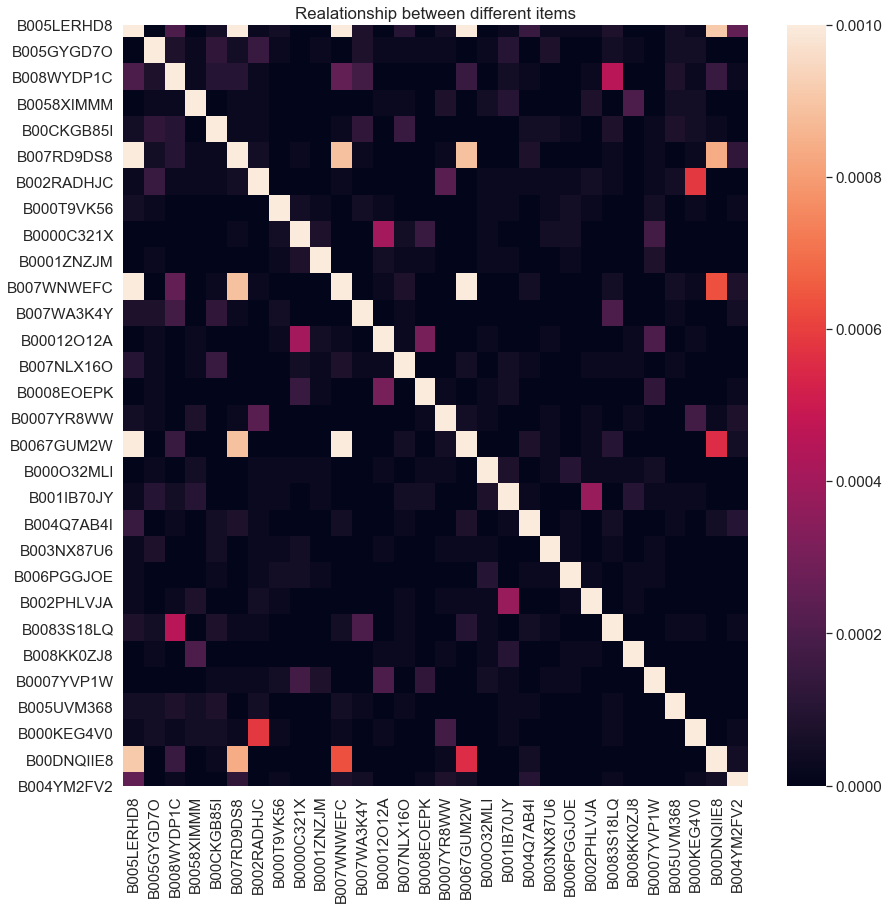

In [25]:
# Plot heat map to show frequently bought together items
plt.figure(figsize=(14, 14))
sns.set(font_scale=1.4)
sns.heatmap(correlation_tb, vmax = 0.001).set_title('Realationship between different items')
plt.savefig('reco_heatmap.png')
plt.show()

In [26]:
# Let's look at 'B0067GUM2W' and 'B007WNWEFC'
a_fashion_df[a_fashion_df['asin'].isin(['B0067GUM2W', 'B007WNWEFC'])].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
170411,A2LESKVQIJC07P,B0067GUM2W,A. Friscia,"[0, 0]","This is just as pictured, but the only thing I...",4.0,Vintage Owl Necklace,1375142400,"07 30, 2013"
170412,ACT7WFZO2XZ3C,B0067GUM2W,"A. Goodman ""PearlieGirlie""","[0, 0]",it is really pretty. chain isn't that long but...,5.0,love,1379894400,"09 23, 2013"
170413,A1POKQ821ZBYQ8,B0067GUM2W,Alexis Humphries,"[0, 0]","its not too big & not too small, just the righ...",5.0,so gorgeous,1388620800,"01 2, 2014"
170414,A90IZ02PXYSFA,B0067GUM2W,Alicia,"[0, 0]",I received this necklace in about 2 weeks (cam...,5.0,Looks just like the pic & nice quality,1375574400,"08 4, 2013"
170415,A7VRH6FW44A0Z,B0067GUM2W,Amazon Customer,"[0, 0]",super cute and adorable did take a while to ge...,4.0,whoo whoo,1389744000,"01 15, 2014"


In [27]:
# Let's look at 'B005LERHD8' and 'B007WNWEFC'
a_fashion_df[a_fashion_df['asin'].isin(['B005LERHD8', 'B007WNWEFC'])].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
161265,A1PMGOX24BWDAZ,B005LERHD8,0902virgo,"[0, 0]","I received the necklace a few days ago,i got o...",5.0,Really cute,1354492800,"12 3, 2012"
161266,A3FCLEFNZ33BW3,B005LERHD8,adversity,"[0, 0]",I CHOSE THIS FOR MY DAUGHTER ALONG WITH ANOTHE...,5.0,GOES WITH ANOTHER ONE,1364256000,"03 26, 2013"
161267,A2LESKVQIJC07P,B005LERHD8,A. Friscia,"[0, 0]",I bought one for myself and one for my daughte...,5.0,"Vintage, Retro Colorful Crystal Owl Pendant an...",1368576000,"05 15, 2013"
161268,A37URRNLNUKSAA,B005LERHD8,"AJccc4Life ""AJccc4Life""","[0, 0]",These are similar to the ones you see in costu...,5.0,Very nice necklace,1361318400,"02 20, 2013"
161269,A1HFSY6W8LJNJM,B005LERHD8,"Alicia7tommy ""Alicia Andrews""","[0, 0]",The owl necklace is really cute but made real ...,4.0,Really Cute,1343001600,"07 23, 2012"


In [28]:
# Question 4 - look at rules!
from mlxtend.frequent_patterns import apriori, association_rules

x = apriori(transaction_df, min_support=0.0025, use_colnames=True)

#take a look at the help for ways we can use this function
rules_df = association_rules(x, metric="lift", min_threshold=1)

In [30]:
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


#### NETWORK ANALYSIS
Here we will make use of graph theory to identify relationships between items. Items will be represented as nodes using different weights (number of times items appear together in the same review). We will come up with a list of recommendations for users based on the items they have bought before.

In [32]:
# Collapse to a series of lists
networks = a_fashion_df.groupby('reviewerID').apply(lambda x: list(x['asin']))
### we can ignore 1 length baskets - no connections
networks = networks[networks.apply(lambda x:len(x) > 1)]

#holding dict
mydict = {}

for i in range(len(networks)):
    #2 combinations of baskets
    for j,k in combinations(networks[i],2):
        # set defauly, and append a 1 for each time it is found
        mydict.setdefault((j,k),[]).append(1)

#make a graph
G = nx.Graph()
#add the edges, if weight is greater than 20 - ie 20 transactions
_ = [G.add_edge(i[0], i[1], weight = len(j)) for i,j in mydict.items() if len(j) > 10];


In [33]:
G

In [34]:
# Check the shape of our graph
len(G)

151

In [35]:
len(G.edges)

235

In [36]:
print(f'first few edges: {list(G.edges())[:5]}')

first few edges: [('B00DMWQOGC', 'B00DMWQVJM'), ('B00DMWQOGC', 'B005LERHD8'), ('B00DMWQOGC', 'B00DMWQOYY'), ('B00DMWQOGC', 'B00DMWQK0W'), ('B00DMWQOGC', 'B007KQRSZM')]


We are interested in knowing which items are the most frequently bought. To do that, we will use the PageRank metrics to check the top 30 items with the most importance or presence in our network

In [37]:
# Calculate pagerank
page_rank = nx.pagerank(G)
page_rank

{'B00DMWQOGC': 0.004985463021974877,
 'B00DMWQVJM': 0.010889601606386688,
 'B008WYDP1C': 0.016749765024145487,
 'B00CN47GXA': 0.008270076765620462,
 'B002RADHJC': 0.00907011992546028,
 'B007HJG36M': 0.004659339056939995,
 'B007RD9DS8': 0.01808511422010159,
 'B00DMWQV38': 0.009933453730336895,
 'B00BNB3A0W': 0.008283033191877294,
 'B00DMWQLB0': 0.0031281931786081674,
 'B00DMWQOYY': 0.013132111534844627,
 'B00DM05BU4': 0.002452589116373658,
 'B00DNQIIE8': 0.013958646522843229,
 'B004Z1CZDK': 0.003395112357754259,
 'B00DM0587K': 0.002126887896032968,
 'B001HEF6W0': 0.006622516556291391,
 'B0025ZPQTS': 0.006622516556291391,
 'B005LERHD8': 0.0306345813865747,
 'B00DM05AAU': 0.0036388795611833062,
 'B0067GUM2W': 0.014138180651637657,
 'B007WNWEFC': 0.018037749172212816,
 'B00CAMCNQ0': 0.004451705863186399,
 'B00975PL9Y': 0.006622516556291391,
 'B009RA63GO': 0.006622516556291391,
 'B007KQRSZM': 0.0048877815787894486,
 'B008UKZ868': 0.005402591786944312,
 'B000F1SCU4': 0.006622516556291391,
 '

In [38]:
# Convert page rank dictionary to pandas dataframe for ease of manipulation
pagerank_df = pd.DataFrame(page_rank.values(), index=page_rank.keys(), columns=['pagerank'])

# Convert pagerank values to percentage and sorting the values
pagerank_df.pagerank = pagerank_df.pagerank * 100
pagerank_df.sort_values('pagerank', ascending=False)

,pagerank
B005LERHD8,3.063458
B007RD9DS8,1.808511
B007WNWEFC,1.803775
B008WYDP1C,1.674977
B005GYGD7O,1.574094
...,...
B006UY80QG,0.149562
B00DMWQO58,0.148026
B008IZMWNM,0.145699
B00DM05BC2,0.144959


In [39]:
pagerank_df['pagerank'].sum()

100.00000000000003

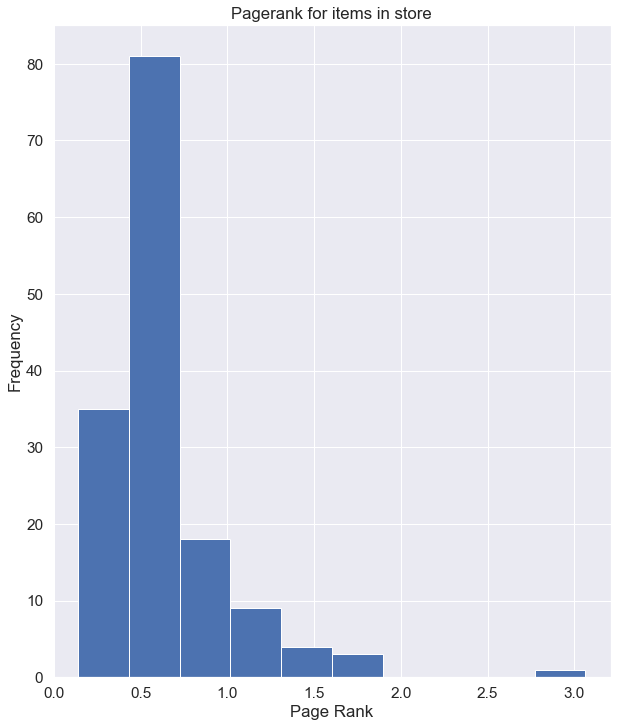

In [40]:
# Distribution of Pagerank for items in store
plt.figure(figsize=(10,12))
plt.hist(pagerank_df['pagerank'], bins=10)
plt.title('Pagerank for items in store')
plt.xlabel('Page Rank')
plt.ylabel('Frequency')
plt.savefig('dist_page.png')
plt.show()

##### Solving the cold start problem
in order to solve the cold start problem which is a situation where we have newly registered customers without any data with regards to their purchase history, we will use the page rank to find the top k-best item that customers reviewed the most 

In [41]:
# Check the top 10 items frequently bought items
best_selling = pagerank_df.nlargest(10, 'pagerank')
best_selling

,pagerank
B005LERHD8,3.063458
B007RD9DS8,1.808511
B007WNWEFC,1.803775
B008WYDP1C,1.674977
B005GYGD7O,1.574094
B0067GUM2W,1.413818
B00DNQIIE8,1.395865
B00DMWQOYY,1.313211
B0058XIMMM,1.270147
B005UVM368,1.253876


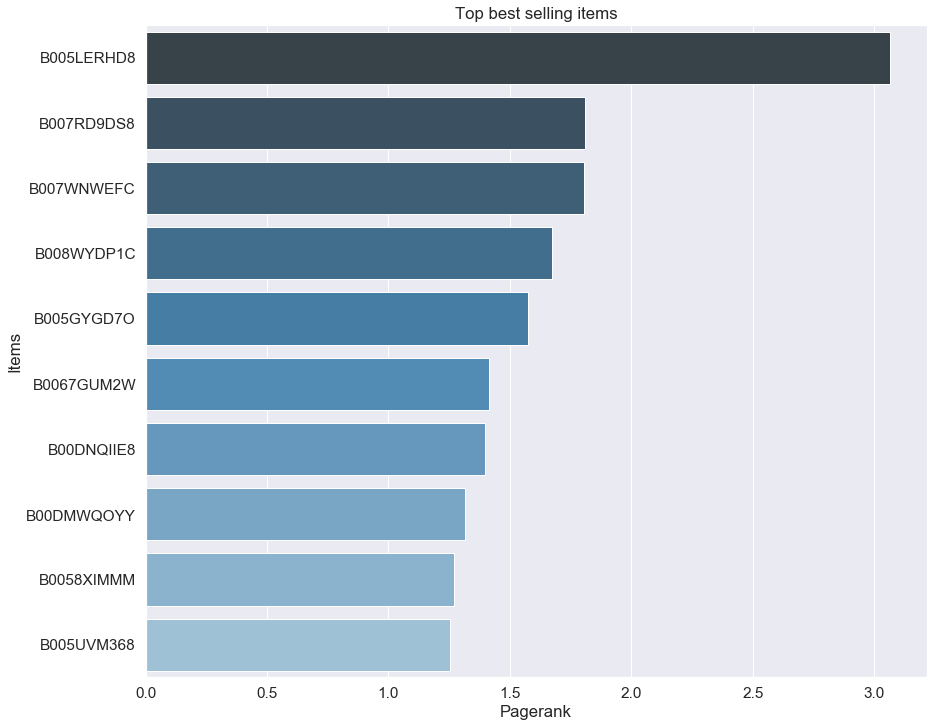

In [42]:
# Top ten best selling items
plt.figure(figsize=(14,12))
sns.set(style="whitegrid")
sns.set(font_scale=1.4)
ax = sns.barplot(x="pagerank", y=best_selling.index, data=best_selling, palette="Blues_d", orient = 'h')
ax.set(title='Top best selling items')
ax.set_ylabel('Items')
ax.set_xlabel('Pagerank')
plt.savefig('pagerank.png')

The above items will be recommended for new customers of whom we have no data about.

In [43]:
# What is this 'BOO5LERHD8' item? 
a_fashion_df[a_fashion_df['asin'] == 'B005LERHD8'].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
161265,A1PMGOX24BWDAZ,B005LERHD8,0902virgo,"[0, 0]","I received the necklace a few days ago,i got o...",5.0,Really cute,1354492800,"12 3, 2012"
161266,A3FCLEFNZ33BW3,B005LERHD8,adversity,"[0, 0]",I CHOSE THIS FOR MY DAUGHTER ALONG WITH ANOTHE...,5.0,GOES WITH ANOTHER ONE,1364256000,"03 26, 2013"
161267,A2LESKVQIJC07P,B005LERHD8,A. Friscia,"[0, 0]",I bought one for myself and one for my daughte...,5.0,"Vintage, Retro Colorful Crystal Owl Pendant an...",1368576000,"05 15, 2013"
161268,A37URRNLNUKSAA,B005LERHD8,"AJccc4Life ""AJccc4Life""","[0, 0]",These are similar to the ones you see in costu...,5.0,Very nice necklace,1361318400,"02 20, 2013"
161269,A1HFSY6W8LJNJM,B005LERHD8,"Alicia7tommy ""Alicia Andrews""","[0, 0]",The owl necklace is really cute but made real ...,4.0,Really Cute,1343001600,"07 23, 2012"


B005LERHD8 is a Piece of necklace with an average star rating of 4.5.

In [45]:
# What is this 'BOO5LERHD8' item? 
a_fashion_df[a_fashion_df['asin'] == 'B0058XIMMM'].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
149567,A3A70Y1TKBIA18,B0058XIMMM,0916,"[1, 2]",These are much more than I expected! The colo...,5.0,Wow!!!!!!,1338681600,"06 3, 2012"
149568,A1AC1ZXX9IBCTT,B0058XIMMM,"AB ""Annie B""","[0, 0]",First time trying a slip-on walking shoe. The...,5.0,Very comfortable.,1393286400,"02 25, 2014"
149569,A2G3V7O4WP5F36,B0058XIMMM,"Abourne ""April""","[0, 0]","I rated these five stars because their cute, c...",5.0,I wear these shoes to walk in,1373500800,"07 11, 2013"
149570,A2A0LQX7E24JI7,B0058XIMMM,Adele,"[0, 0]","However, it was too large for me to really try...",5.0,The shoe is so light,1375315200,"08 1, 2013"
149571,A1CLE8JPZ5JTCV,B0058XIMMM,ADiamondToo,"[0, 0]",I originally purchased them just for everyday ...,5.0,Best shoes EVER!,1380585600,"10 1, 2013"


B0058XIMMM is a shoe with an average star rating of 4.5.

In [46]:
%%html
<img src = 'img/B0058XIMMM.jpg', width=180, height=150>

Is our network completely connected? How many sub-clusters are present?

In [47]:
# is the graph completely connected?
nx.is_connected(G)

False

From the above, we see that our network isnt completely connected - implying that there will be sub - clusters.


In [48]:
subgraphs = list(nx.connected_components(G))
len(subgraphs)

36

In [49]:
for subgraph in subgraphs:
    print(len(subgraph), end=' ')

39 14 4 2 2 2 2 3 5 2 2 2 7 2 5 2 2 3 2 2 2 4 5 9 2 2 2 2 2 2 3 2 2 2 2 4 

In [50]:
item_list = list(subgraphs[0])
#x[x['StockCode'].isin(item_list)]['Description'].unique()
a_fashion_df[a_fashion_df['asin'].isin(item_list)].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
142089,AVNA8AINEVRTG,B004Z1CZDK,Abby,"[0, 0]","You get what you paid for, the picture does it...",1.0,Horrible,1377993600,"09 1, 2013"
142090,A24PXWD67V1A4Z,B004Z1CZDK,aimee lara,"[0, 0]",I thought that this might be cute to wear on m...,1.0,does not fit!!,1395705600,"03 25, 2014"
142091,A17VF80XLCCZTN,B004Z1CZDK,"A. Lane ""Baking Freak""","[1, 1]",It was cheap as heck (under $1) so I was reall...,2.0,The back doesn't stay on,1382313600,"10 21, 2013"
142092,A90IZ02PXYSFA,B004Z1CZDK,Alicia,"[0, 0]",I received this today and it only took about 1...,5.0,Just as pictured & good product!,1372204800,"06 26, 2013"
142093,A33IYETJ5C08YM,B004Z1CZDK,Amazon Customer,"[0, 0]",Unique item at a great price. I was testing t...,4.0,Fits me fine. Regular sized ears.,1380585600,"10 1, 2013"


In [51]:
# List Items in subgraph 1
item_list = list(subgraphs[1])
a_fashion_df[a_fashion_df['asin'].isin(item_list)]['reviewText'].head()

189730    This shirt is super cute with a pair of jeans,...
189731    I'm 5'3 and this dress fits nice. I wear it wi...
189732    Is different fabric that the gray model and wh...
189733    This sweater shirt fit a bit larger than expec...
189734    I think its important for foreigner companies ...
Name: reviewText, dtype: object

In [ ]:
Clearly, the products in subgraph 1 are typically fabrics.

In [52]:
# Question 3 - looking at cliques
cliques_generator = nx.find_cliques(G)
cliques_generator

<generator object find_cliques at 0x0000017E3827A3C8>

In [53]:
# Iterate through the cliques and add to a list if clique size > 5
# When len(list) >= 5, then stop
cliques_gt_5 = list()

while(len(cliques_gt_5) < 5):
    clique = next(cliques_generator)
    if len(clique) >= 5:
        cliques_gt_5.append(clique)

In [54]:
cliques_gt_5

[['B005LERHD8',
  'B00DM05AAU',
  'B00DMWQOYY',
  'B007RD9DS8',
  'B00DMWQK0W',
  'B00DMWQVJM'],
 ['B005LERHD8',
  'B007WNWEFC',
  'B007RD9DS8',
  'B00DMWQKWA',
  'B00DMWQOYY',
  'B00DMWQVJM',
  'B00DMWQV38',
  'B00BNB3A0W'],
 ['B005LERHD8',
  'B007WNWEFC',
  'B007RD9DS8',
  'B00DMWQKWA',
  'B00DMWQOYY',
  'B00DMWQVJM',
  'B00DMWQV38',
  'B00DNQIIE8'],
 ['B005LERHD8',
  'B007WNWEFC',
  'B007RD9DS8',
  'B00DMWQKWA',
  'B00DMWQOYY',
  'B00DMWQVJM',
  'B008RUOCJU',
  'B00DNQIIE8'],
 ['B005LERHD8',
  'B007WNWEFC',
  'B007RD9DS8',
  'B0067GUM2W',
  'B00DMWQOYY',
  'B00DMWQK0W',
  'B00DMWQV38',
  'B00DM05D5C',
  'B00DNQIIE8']]

In [55]:
for clique in cliques_gt_5:
    print(len(clique))

6
8
8
8
9


In [56]:
# Investigate 1 clique
a_fashion_df[a_fashion_df['asin'].isin(cliques_gt_5[4])]['reviewText'].unique()

array(['I received the necklace a few days ago,i got one for me and my sisters. You can not beat this price and i really didnt care where it can from.. Even though it was shipped from china it did not take that long to be delivered to me which was good. I would definitely order from again.',
       'I CHOSE THIS FOR MY DAUGHTER ALONG WITH ANOTHER ONE LIKE THIS SO SHE COULD CHOOSE WHICH ONE AND SHE WAS HAPPY WITH THIS ITEM',
       "I bought one for myself and one for my daughter. We both wear them very often, and have had many compliments. It goes with all clothing, and looks very pretty. It's very substantial, but not overly heavy. The stones are nice and the colors are great.",
       ...,
       'I love owls so I wear these when I where those colors,I love my jewelry to march my clothing,they are great',
       'I purchased this sector a big eyed friednd of mine.  She absolutely adored  it.  Very trendy and a  great price',
       'these earrings, wow, They are so cute, and well mad

In [57]:
cliques_gt_5[4]

['B005LERHD8',
 'B007WNWEFC',
 'B007RD9DS8',
 'B0067GUM2W',
 'B00DMWQOYY',
 'B00DMWQK0W',
 'B00DMWQV38',
 'B00DM05D5C',
 'B00DNQIIE8']

In [83]:
G.get_edge_data('B005LERHD8', 'B0067GUM2W')

{'weight': 47}

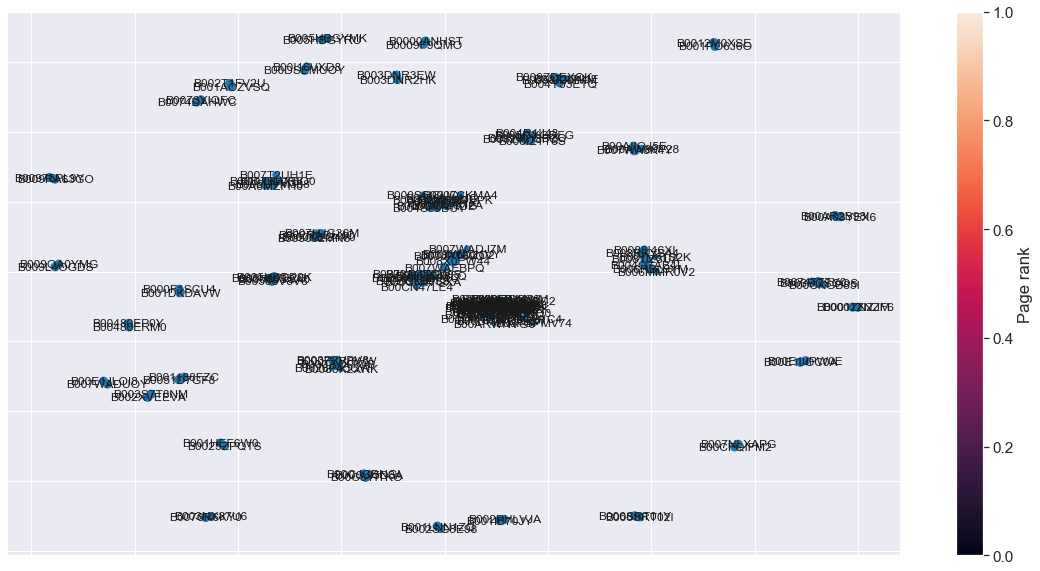

In [54]:
# PLt network graphs
from networkx.drawing.layout import spring_layout
plt.figure(figsize=(20,10))
pos = spring_layout(G)
n = nx.draw_networkx_nodes(G, pos,  cmap='YlOrRd_r', 
                           node_size=pagerank_df['pagerank']*100.0)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
cbar= plt.colorbar(n)
cbar.set_label('Page rank', rotation=90)
plt.show()

In [58]:
# Create a function that will make recommendations based on asin
def my_network_recommender(asin):
    
    # Find all the neighbors
    neighbors_df = pd.DataFrame(list(G.neighbors(asin)))
    neighbors_df.columns = ['node']
    
    # Find the weights to each neighbor
    neighbors_df['node'].apply(lambda x: G.get_edge_data(asin, x)['weight'])
    neighbors_df['weight'] = neighbors_df['node'].apply(lambda x: G.get_edge_data(asin, x)['weight'])
   
    # Return a random choice of neighbor, proportionally by edge weight
    reco = neighbors_df.sample(5, weights='weight')
    
    return reco

In [59]:
my_network_recommender('B0067GUM2W')

,node,weight
9,B00DNQIIE8,22
12,B00DM05FV4,11
10,B008RUOCJU,14
4,B00DM05D5C,14
7,B00DMWQV38,21


In [60]:
# Investigate 1 clique
a_fashion_df[a_fashion_df['asin'].isin(cliques_gt_5[4])]['reviewText'].unique()

array(['I received the necklace a few days ago,i got one for me and my sisters. You can not beat this price and i really didnt care where it can from.. Even though it was shipped from china it did not take that long to be delivered to me which was good. I would definitely order from again.',
       'I CHOSE THIS FOR MY DAUGHTER ALONG WITH ANOTHER ONE LIKE THIS SO SHE COULD CHOOSE WHICH ONE AND SHE WAS HAPPY WITH THIS ITEM',
       "I bought one for myself and one for my daughter. We both wear them very often, and have had many compliments. It goes with all clothing, and looks very pretty. It's very substantial, but not overly heavy. The stones are nice and the colors are great.",
       ...,
       'I love owls so I wear these when I where those colors,I love my jewelry to march my clothing,they are great',
       'I purchased this sector a big eyed friednd of mine.  She absolutely adored  it.  Very trendy and a  great price',
       'these earrings, wow, They are so cute, and well mad

In [ ]:
Items in the clique above seem to be Jewelries

In [61]:
# What is this 'B0067GUM2W' item? 
a_fashion_df[a_fashion_df['asin'] == 'B0067GUM2W']['reviewText']

170411    This is just as pictured, but the only thing I...
170412    it is really pretty. chain isn't that long but...
170413    its not too big & not too small, just the righ...
170414    I received this necklace in about 2 weeks (cam...
170415    super cute and adorable did take a while to ge...
                                ...                        
170589    One of the links on the necklace was broken wh...
170590    The chain broke off of it in one day. So the w...
170591    This necklace is really cute. It's really good...
170592    Cute little guy. Great addition to my layering...
170593    I love this necklace. It looks great and is aw...
Name: reviewText, Length: 183, dtype: object

In [105]:
# What is this 'B0067GUM2W' item? 
a_fashion_df[a_fashion_df['asin'] == 'B008RUOCJU']['reviewText']

218739    BROKEN.....This thing did not last long at all...
218740    Well, this is my second time buying this item ...
218741    I see these types of rings everywhere but none...
218742    It was very small, i guess i was expecting a l...
218743    I bought this as a Christmas gift for my daugh...
                                ...                        
218848    This is a very cute piece of jewelry. My daugh...
218849    This ring is so unique.  I love the way people...
218850    This was a good purchase, it came came earlier...
218851    I knew I was ordering cheap rings, that was no...
218852    I really liked this ring but the only down sid...
Name: reviewText, Length: 114, dtype: object

###### Content Based filtering Algorithm
This method uses attributes of the content to recommend similar content. We will calculate and use tf-idf weight which shows us the degree to which words are important in a given document.

In [91]:
#Need this helper function to look up an item TFIDF by its name.
def get_item(asin, tfidf_scores, keys):
    row_id = keys.get(asin)
    row = tfidf_scores[row_id,:]
    return row

We create a function below to help us in the NLP stage - tokenization,lemmitization, stemming and removing stop words and punction. We will be using the 'review' column of our dataframe to extract the features.

In [92]:
# Function to tokenise 
def my_tokenizer(review):
    listofwords = review.split(' ')
    listofstemmed_words = []
    stemmer = nltk.stem.PorterStemmer()
    
    for word in listofwords:
        # Remove stopwords
        if word in ENGLISH_STOP_WORDS: continue
        # Stem words
        stemmed_word = stemmer.stem(word)
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            stemmed_word = stemmed_word.replace(punctuation_mark, '').lower()
        listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

index = 0
keys = {}
for item in a_fashion_df.itertuples(): 
    key = item[1]
    keys[key] = index
    index += 1
    
# Get out the tokens from the movie overviews
from sklearn.feature_extraction.text import TfidfVectorizer

mytfid= TfidfVectorizer(tokenizer = my_tokenizer, min_df = 1000, ngram_range = (1,3))

mytfid.fit(a_fashion_df.reviewText)
dtm = mytfid.transform(a_fashion_df.reviewText)


In [93]:
dtm.shape

(278225, 1381)

In [94]:
keys

{'A1KLRMWW2FWPL4': 227846,
 'A2G5TCU2WDFZ65': 246536,
 'A1RLQXYNCMWRWN': 217155,
 'A8U3FAMSJVHS5': 185717,
 'A3GEOILWLK86XM': 275343,
 'A27UF1MSF3DB2': 276734,
 'A16GFPNVF4Y816': 219335,
 'A2M2APVYIB2U6K': 219906,
 'A1NJ71X3YPQNQ9': 241220,
 'A3EERSWHAI6SO': 155073,
 'AX1QE6IR7CHXM': 252772,
 'A2A2WZYLU528RO': 188980,
 'A391EXIT5TFP72': 160828,
 'A34ATJR9KFIXL9': 238447,
 'AJ6B83I4YJHYW': 259330,
 'A26A4KKLAVTMCC': 277018,
 'A1MXJVYXE2QU6H': 223151,
 'A2XJ13PIXVJFJH': 275119,
 'A287XY94U7JDM8': 182029,
 'A1JR9KKF6UKUWW': 189879,
 'A2SX7X8QGQVCJU': 148412,
 'A2Q6UWR5PBHTJS': 224769,
 'AJZPHJR944IBB': 237313,
 'A2WNN1DQVL4LH5': 156755,
 'A1ZPOCG2ST2CY3': 156011,
 'A1WDJIFL2F4QJA': 221046,
 'A3RB1JA72Z0TUN': 219834,
 'A1JC50F14SLAEV': 236950,
 'A8WD29DKN8ZC3': 268012,
 'A1F7YU6O5RU432': 274954,
 'A3INPLAFCMRI3I': 152919,
 'A3NHUQ33CFH3VM': 277087,
 'A253TILLU81VZK': 138451,
 'A28QH3KX709FFQ': 246174,
 'A1R377IPZOKLMM': 268651,
 'A3U6J0DLLDEWM2': 170729,
 'A1ZU55TM45Y2R8': 201129,
 'A1NIGU

In [95]:
get_item('A1PZTLO2KKVYT7', dtm, keys)

<1x1381 sparse matrix of type '<class 'numpy.float64'>'
	with 103 stored elements in Compressed Sparse Row format>

In [96]:
# Check similarity between two items
item_1 = get_item('A1PZTLO2KKVYT7', dtm, keys)
item_2 = get_item('A3PYL1CS4PCIX1', dtm, keys)

print("Similarity:", cosine_similarity(item_1, item_2))

Similarity: [[0.19948021]]


In [101]:
# Create function to make calculate similarity score and make recommendations
def content_recommender(asin, tfidf_scores, items) :
    
    #Store the results in this DF
    similar_items = pd.DataFrame(columns = ["item","similarity"] )
    
    #The movie we are finding movies similar to
    item_1 = get_item(asin, tfidf_scores, keys)
    
    #Go through ALL the movies
    for item in items['asin'] :
                
        #Find the similarity of the two items
        item_2 = get_item(asin, tfidf_scores, keys)
        similarity = cosine_similarity(item_1, item_2)
        similar_items.loc[len(similar_items)] = [item, similarity[0][0]]

    return similar_items.sort_values(by=['similarity'],ascending=False)[1:]

In [102]:
content_recommender('A1PZTLO2KKVYT7', dtm, a_fashion_df) 

,item,similarity
185489,B00794W7JC,1.0
185475,B00794W7JC,1.0
185476,B00794W7JC,1.0
185477,B00794W7JC,1.0
185478,B00794W7JC,1.0
...,...,...
92747,B00309HQPK,1.0
92748,B00309HQPK,1.0
92749,B00309HQPK,1.0
92750,B00309HQPK,1.0


##### NEAREST NEIGHBOR ITEM BASED COLLABORATIVE FILTERING - - UNSUPERVISED LEARNING
Here, we will use Nearest Neighbor to identify and group (cluster) similar items together. We will make recommendations based on that. We will be using the cosine similarity score to calculate the distances between products in space. Cosine Similarity is used here as it is more useful for instances when we do not want magnitude to skew the results. 

Let's take a look at the distribution of reviews across items again to come up with a threshold to decide products to use.

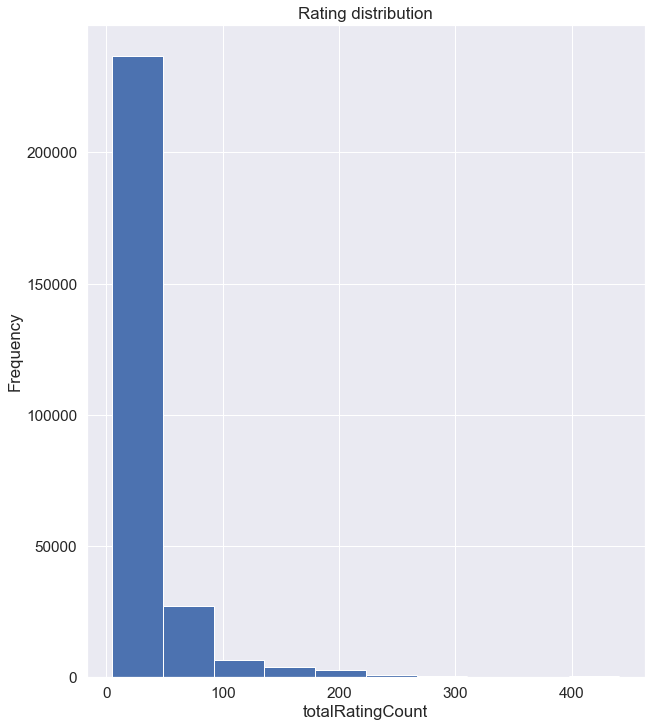

In [112]:
# Lets take a look at the Distribution of 'totalRatingCount'
plt.figure(figsize=(10,12))
plt.hist(a_fashion1.totalRatingCount, bins=10)
plt.title('Rating distribution')
plt.xlabel('totalRatingCount')
plt.ylabel('Frequency')
plt.show()

From the above graph, we will only recommend products that have more than 30 total ratings to better ensure the qaulity of recommendations made.

In [113]:
# set threshold
popularity_threshold = 30
a_fashion_popular = a_fashion1.query('totalRatingCount >= @popularity_threshold')
a_fashion_popular.shape

(75343, 10)

We end up with 75,343 reviews from 278,677 reviews

In [114]:
item_pivot = a_fashion_popular.pivot_table(values = 'overall', index = 'reviewerID', columns = 'asin').fillna(0)
item_pivot

asin,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B00007GDAL,B0000868O9,B000086910,B0000891K0,B00008ECKG,B00008I8YM,...,B00FGQB1C4,B00FJ5LI3O,B00FY7VAQM,B00G9BLGW0,B00GI6IASO,B00GKC1KC4,B00H2SU5ZI,B00I0XXR5E,B00IE5QR64,B00IJHIKZ8
reviewerID,,,,,,,,,,,,,,,,,,,,,
A001114613O3F18Q5NVR6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00146182PNM90WNNAZ5Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00165422B2GAUE3EL6Z0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00354001GE099Q1FL0TU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00475741WVLQL5CVWK2Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZKXNSXR6KBE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZMQ85DPFEG3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZNK89PXD006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
# Instantiate model
my_knn = NearestNeighbors(n_neighbors = 5, algorithm = 'brute', metric = 'cosine')
# Fit model
my_knn = my_knn.fit(item_pivot.T.values)
item_distances, item_indices = my_knn.kneighbors(item_pivot.T.values)

In [116]:
item_distances


array([[0.00000000e+00, 9.66438448e-01, 9.67576460e-01, 9.68356213e-01,
        9.68657550e-01],
       [1.11022302e-16, 9.53968733e-01, 9.61053804e-01, 9.66008043e-01,
        9.66016812e-01],
       [0.00000000e+00, 9.61025458e-01, 9.62702392e-01, 9.64692435e-01,
        9.66008043e-01],
       ...,
       [0.00000000e+00, 9.01133956e-01, 9.30699472e-01, 9.33156763e-01,
        9.52236285e-01],
       [0.00000000e+00, 9.15216031e-01, 9.15642875e-01, 9.41686908e-01,
        9.42696110e-01],
       [0.00000000e+00, 9.30699472e-01, 9.36527599e-01, 9.53626726e-01,
        9.55575052e-01]])

In [117]:
# Loop item_pivot to get lists of items with their closest neighbors
items_dict = {}
for i in range(len(item_pivot.T.index)):
    item = item_indices[i]
    col_names = item_pivot.T.index[item].tolist()
    items_dict[item_pivot.T.index[i]] = col_names

In [118]:
items_dict

{'B00005TQI7': ['B00005TQI7',
  'B004F9QINK',
  'B006T52W0G',
  'B00BTUB9GY',
  'B00007GDAL'],
 'B00006XXGO': ['B00006XXGO',
  'B006DU3EM2',
  'B000TGPR4O',
  'B000072UMJ',
  'B000LFG4A4'],
 'B000072UMJ': ['B000072UMJ',
  'B000K7CFX8',
  'B003N63ESI',
  'B001TQ1T4U',
  'B00006XXGO'],
 'B000074RL3': ['B000074RL3',
  'B000B14ERS',
  'B002RADHJC',
  'B004I44KO6',
  'B005VNFCZO'],
 'B00007GDAL': ['B00007GDAL',
  'B001M5GQ8W',
  'B009XM2Y64',
  'B000FOJZVQ',
  'B001HTZ134'],
 'B0000868O9': ['B0000868O9',
  'B0000ZDSDG',
  'B000086910',
  'B0007QMK2S',
  'B001188FZC'],
 'B000086910': ['B000086910',
  'B0064HGDB8',
  'B005P23BB8',
  'B0012M0XSE',
  'B0000868O9'],
 'B0000891K0': ['B0000891K0',
  'B000HVRK6E',
  'B00968D8ZG',
  'B00E8CJYNU',
  'B0002LICNO'],
 'B00008ECKG': ['B00008ECKG',
  'B000YGH3E6',
  'B004GCIMZ8',
  'B003WT1AXM',
  'B005TD78HG'],
 'B00008I8YM': ['B00008I8YM',
  'B007AH59JS',
  'B0007QMUCS',
  'B003BNZ3DW',
  'B0046LE51Y'],
 'B00008ID0B': ['B00008ID0B',
  'B000ARTQG2',
  'B

In [75]:
item_similar = {'img_B00005TQI7' :'img/B00005TQI7.jpg',
                'img_B004F9QINK' :'img/B004F9QINK.jpg', 
                'img_B006T52W0G':'img/B006T52W0G.jpg',
                'img_B00BTUB9GY' : 'img/B00BTUB9GY.jpg',
                'img_B00007GDAL' : 'img/B00007GDAL.jpg'}

In [76]:
item_similar

{'img_B00005TQI7': 'img/B00005TQI7.jpg',
 'img_B004F9QINK': 'img/B004F9QINK.jpg',
 'img_B006T52W0G': 'img/B006T52W0G.jpg',
 'img_B00BTUB9GY': 'img/B00BTUB9GY.jpg',
 'img_B00007GDAL': 'img/B00007GDAL.jpg'}

We wouldnt want to recommend products to customers that they have reviewed or rated before But first, we will try to identify products each user has rated before

In [124]:
# Loop through item_pivot to get products each customer has rated before.
rate = {}
rows_indexes = {}
for i, row in item_pivot.iterrows():
    rows = [x for x in range (0, len(item_pivot.columns))]
    item = list(zip(row.index, row.values, rows))
    rated = [(x,z) for x,y,z in item if y != 0]
    index = [i[1] for i in rated]
    row_names = [i[0] for i in rated]
    rows_indexes[i] = index
    rate[i] = row_names

In [125]:
rows_indexes

{'A001114613O3F18Q5NVR6': [240],
 'A00146182PNM90WNNAZ5Q': [274],
 'A00165422B2GAUE3EL6Z0': [1096, 1098, 1324],
 'A00354001GE099Q1FL0TU': [673],
 'A00475741WVLQL5CVWK2Z': [1181],
 'A00635603LUUJQPQWSJW1': [5],
 'A007227915NZZC7B6P030': [1329],
 'A0107229P6G90UKRJYQW': [374, 409, 1084],
 'A01103631SAT3BPLD52LV': [1108],
 'A01194842MEQEG9QC0W1M': [275, 278],
 'A0145698H8AAYMRXLBD8': [98, 103, 531],
 'A0148968UM59JS3Y8D1M': [254, 303],
 'A01749481KYG2RR0SF6GR': [904, 1047, 1306, 1367],
 'A02155413BVL8D0G7X6DN': [79, 991],
 'A021943320Y3C5B58IY79': [994, 1008, 1220],
 'A022899328A0QROR32DCT': [995, 1419],
 'A02755422E9NI29TCQ5W3': [285, 300, 916, 941],
 'A03236882LUP4ARMDDMXU': [599, 603, 878, 1411],
 'A034597326Z83X79S50FI': [221, 900],
 'A036147939NFPC389VLK': [492, 898],
 'A03756272FRRX98COZNG7': [92, 1284],
 'A04095881JK7GJRJYSY4N': [177, 1199, 1387, 1392],
 'A04302121C7RQ2ZU3PZTJ': [844, 1340],
 'A04559521ZZJ87IMRVPME': [13, 135],
 'A048681111PT7XGLOEOGX': [392],
 'A0508575POGBTVG7AGW

In [126]:
rate

{'A001114613O3F18Q5NVR6': ['B000J6ZYL0'],
 'A00146182PNM90WNNAZ5Q': ['B000MX3SH2'],
 'A00165422B2GAUE3EL6Z0': ['B007WADN4G', 'B007WAEBPQ', 'B00BLW2PZY'],
 'A00354001GE099Q1FL0TU': ['B003RYZY8E'],
 'A00475741WVLQL5CVWK2Z': ['B008OOMB0Q'],
 'A00635603LUUJQPQWSJW1': ['B0000868O9'],
 'A007227915NZZC7B6P030': ['B00BPNX7MO'],
 'A0107229P6G90UKRJYQW': ['B0012M0V7W', 'B0018P3EAO', 'B007VIWFXO'],
 'A01103631SAT3BPLD52LV': ['B007XW2UG0'],
 'A01194842MEQEG9QC0W1M': ['B000MXIMHI', 'B000N3Q78I'],
 'A0145698H8AAYMRXLBD8': ['B0007SUEVA', 'B0007XA0FU', 'B002ETVLZ8'],
 'A0148968UM59JS3Y8D1M': ['B000KXW528', 'B000P50VWM'],
 'A01749481KYG2RR0SF6GR': ['B005I0EFGM',
  'B007GB6WHQ',
  'B00B1VAY2Q',
  'B00D1MR8YU'],
 'A02155413BVL8D0G7X6DN': ['B0006MY4EU', 'B006OY37WO'],
 'A021943320Y3C5B58IY79': ['B006QF0W6K', 'B006VMNT5E', 'B0095LJRDQ'],
 'A022899328A0QROR32DCT': ['B006QQOY5E', 'B00F2ZX4XS'],
 'A02755422E9NI29TCQ5W3': ['B000NGKLNC',
  'B000OTRDZ2',
  'B005LMTW6K',
  'B005UVTZ9G'],
 'A03236882LUP4ARMDDMXU':

In [139]:
# Convert to numeric
item_pivot = item_pivot.apply(pd.to_numeric, errors='ignore')

In [145]:
# Loop through rows_indexes above to get recommendation for each user based on the items they reviewed before
top_recs = {}
for user, v in rows_indexes.items():
    item_index = [j for i in item_indices[v] for j in i]
    item_dist = [j for i in item_distances[v] for j in i]
    item = list(zip(item_dist, item_index))
    diction = {i:d for d,i in item if i not in v}
    zipped = list(zip(diction.keys(), diction.values()))
    sort = sorted(zipped, key = lambda x: x[1])
    recommendations = [(item_pivot.columns[i], d) for i,d in sort]
    top_recs[user] = recommendations


In [147]:
# Function to take reviewerId and number of recommendations to be made.
def makeRecommendation(user, num_recs):
    for k, v in top_recs.items():
        if user == k:
            print('The following items are recommended for you:')
            for i in v[:num_recs]:
                print('{} with similarity: {:.4f}'.format(i[0], 1 - i[1]))

In [149]:
# Make recommendation
makeRecommendation('A001114613O3F18Q5NVR6', 4)

The following items are recommended for you:
B001H0F2ZA with similarity: 0.0906
B0010EBF9K with similarity: 0.0870
B00719Z59Y with similarity: 0.0862
B005CSOGD2 with similarity: 0.0679


In [159]:
# Let's check the items recommended to see if are any similarities between them
# What is this 'B0010EBF9K' item? 
a_fashion_df[a_fashion_df['asin'] == 'B0010EBF9K']['reviewText'].head()

50097    Pretty light blue .  Washes up great and just ...
50098    Good fit, good quality, good weight, I like it...
50099    I wanted a light gray cotton workout shirt.  T...
50100    This is a very great shirt for working out. It...
50101    I would recommend this item to my friends and ...
Name: reviewText, dtype: object

In [153]:
# Let's check the items recommended to see if are any similarities between them
# What is this 'B00719Z59Y' item? 
a_fashion_df[a_fashion_df['asin'] == 'B00719Z59Y']['reviewText'].head()

181428    Fits and feels good. Nice cheap pair of workou...
181429    These shorts are great for working out and cam...
181430    These Russell shorts are well made, comfortabl...
181431    I am 50 and very large.  These shorts arrived ...
181432    Great shorts. Fit nicely. Not long or baggy an...
Name: reviewText, dtype: object

In [154]:
# What is this 'B001H0F2ZA' item? 
a_fashion_df[a_fashion_df['asin'] == 'B001H0F2ZA']['reviewText'].head()

65365    This shirt is great.  It keeps my husband cool...
65366    The more I buy Champion products, the more I r...
65367    Champion is quickly becoming my go to wear.  I...
65368    Love this tee.  Champion usually puts out dece...
65369    They are a little bit wide, the length is ok! ...
Name: reviewText, dtype: object

From the reviews of the items recommended, We can see that the recommendations made above are sports shirts. This makes sence as the items are similar

In [163]:
%%html
<table>
<p>Customers like you bought this too:
    <tr>
        <td><img src="img/B001H0F2ZA.jpg", width=200, height=200></>
        <td><img src="img/B0010EBF9K.jpg", width=200, height=200></td>
        <td><img src="img/B004VO7UE0.jpg", width=200, height=200></td>
        <td><img src="img/B000J6ZYL0.jpg", width=200, height=200></td>
</table>


</>,,


##### Model Evaluation
To evaluate how well our model does in recommending products to customers, we will use the Root Squared Mean Error Metrics.

In [165]:
# Get similarity score
item_distance = 1 - item_distances
item_distances

array([[0.00000000e+00, 9.66438448e-01, 9.67576460e-01, 9.68356213e-01,
        9.68657550e-01],
       [1.11022302e-16, 9.53968733e-01, 9.61053804e-01, 9.66008043e-01,
        9.66016812e-01],
       [0.00000000e+00, 9.61025458e-01, 9.62702392e-01, 9.64692435e-01,
        9.66008043e-01],
       ...,
       [0.00000000e+00, 9.01133956e-01, 9.30699472e-01, 9.33156763e-01,
        9.52236285e-01],
       [0.00000000e+00, 9.15216031e-01, 9.15642875e-01, 9.41686908e-01,
        9.42696110e-01],
       [0.00000000e+00, 9.30699472e-01, 9.36527599e-01, 9.53626726e-01,
        9.55575052e-01]])

In [166]:
# predict the rating of what movies are associated with another movie
predictions = item_distances.T.dot(item_pivot.T.values) / np.array([np.abs(item_distances.T).sum(axis = 1)]).T
predictions

array([[0.        , 0.00795229, 0.02733598, ..., 0.00795229, 0.        ,
        0.        ],
       [0.00348819, 0.00283043, 0.00981324, ..., 0.0057531 , 0.00346716,
        0.00434884],
       [0.00340413, 0.00277631, 0.0098089 , ..., 0.00561712, 0.00345829,
        0.00427115],
       [0.00337188, 0.00277749, 0.00993063, ..., 0.00563775, 0.00346897,
        0.00426361],
       [0.00341722, 0.00278178, 0.01004426, ..., 0.00561558, 0.00348009,
        0.00424535]])

In [167]:
ground_truth = item_pivot.T.values[item_distances.argsort()[0]]
ground_truth

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [168]:
# method to calculate error rate using rmse
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [169]:
error_rate = rmse(predictions, ground_truth)
print('Accuracy: {:.3f}'.format(100 - error_rate))
print('RSME: {:.5f}'.format(error_rate))

Accuracy: 95.420
RSME: 4.58010


###### CONCLUSION AND FUTUTRE WORK
We were able to make use of market basket analysis, network analysis, Nearest Neighbors algorithm and Content and collaborative based filtering algorithms to make recommendations to users based on their purchase history. Due to time constrain, we weren't able to implement the chatbot feature. However, this will be done. I also plan to deploy the model as an app on shopify app store so that store owners can install on their store.